In [1]:
using LinearAlgebra
using Symbolics
using Catalyst
using Plots
using JumpProcesses
using LaTeXStrings

4.1 Verification of MCTT by Product-form Distribution

In [2]:
crn1 = @reaction_network begin
    k, A --> B
    1.0, B --> A
end

Model ##ReactionSystem#230
States (2):
  A(t)
  B(t)
Parameters (1):
  k

Writing function to generate stationary distribution using MCTT:

In [3]:
function mctt_for_crn1(k::Float64, N::Int64)
    states = N + 1
    P = Matrix{Float64}(undef, states, states)
    for i in 1:states, j in 1:states
        P[i, j] = 0.0
    end
    for i in 0:N
        if i < N
            P[i+1, i+2] = 1*(N-i)  # Pi,i+1
        end
        if i > 0
            P[i+1, i] = k* (i)         # Pi,i-1
        end
        P[i+1, i+1] = -(k * (i) + 1 *(N-i))  # Pi,i
    end
    n=N+1
    z=Float64[]
    for i in 1:n
        minor = P[[1:i-1; i+1:n], [1:i-1; i+1:n]]
        pi = det(minor)
        push!(z,pi)
    end
    s = sum(z)
    values = [zi / s for zi in z]
    x_labels = ["($i, $(N-i))" for i in 0:N]
    hist = bar(values, 
               title="Stationary distribution for k=100, N=8",
               xlabel="States", 
               ylabel="Stationary Probability",
               xticks=(1:N+1, x_labels),
               legend=false,
               color=:blue,
               width=0.5)
    #display(hist)
    return values
end

mctt_for_crn1 (generic function with 1 method)

Writing function to generate stationary distribution using product-form stationary distribution:

In [4]:
function product_poisson(k::Float64,N::Int64)
    c=[1/(k+1), k/(k+1)]
    states = N+1
    x_labels = ["($i, $(N-i))" for i in 0:N]
    states = [(i, N - i) for i in 0:N]
    function compute_probability(state)
        # Unpack the state
        A,B = state
        # Define the lambda values for the current state configuration
        lambdas = [
            c[1]^A, c[2]^B,
        ]
        # Sum lambda values according to the formula and take the product
        lambda_product = prod(lambdas)
        fact = [factorial(A), factorial(B)]
        # Compute P using the formula: exp(-Sum lambda_Species) * Product(lambda_species^k_i)
        return lambda_product / prod(fact)
    end
    z=[]
    # Calculate and print P for each state
    for state in states
        P = compute_probability(state)
        push!(z,P)
    end
    T=sum(z)
    z=z/T
    labels = [i for i in 1:length(states)]
    #display(bar(labels, z, xlabel="States", ylabel=L"\pi_{ProductPoisson}",xticks=(1:N+1, x_labels), legend=false, title="Stationary Distribution using Product Poisson"))
    return z
end

product_poisson (generic function with 1 method)

Defining the kl divergence function and computing it for different values of k:

In [6]:
function kl_divergence(true_data, model_data)
    # Normalize both distributions
    true_data = true_data / sum(true_data)
    model_data = model_data / sum(model_data)
    
    # Calculate KL divergence
    divergence = sum(true_data .* log.(true_data ./ model_data))
    return divergence
end

results = []
Z=[0.01,0.1,1.0,10.0,100.0]

for t in 1:5
    k=Z[t]
    model_predictions = mctt_for_crn1(k, 8)
    true_data = product_poisson(k,8)
    divergence = kl_divergence(true_data, model_predictions)
    
    push!(results, (k, divergence))
end
results

5-element Vector{Any}:
 (0.01, -8.864264627755601e-18)
 (0.1, -7.812419383532859e-17)
 (1.0, -4.336808689942024e-17)
 (10.0, 6.630535429933363e-17)
 (100.0, -6.758235813881639e-18)

It is exactly same!!

4.2.2 Example 1: Simple Reversible CRN A<->B 

In [20]:
crn1 = @reaction_network begin
    k, A --> B
    1.0, B --> A
end

Model ##ReactionSystem#256
States (2):
  A(t)
  B(t)
Parameters (1):
  k

In [21]:
# Function that will generate stationary distribution for given k and N for the above CRN (Taken from Chapter 3)
function mctt_for_crn1(k::Float64, N::Int64)
    states = N + 1
    P = Matrix{Float64}(undef, states, states)
    for i in 1:states, j in 1:states
        P[i, j] = 0.0
    end
    for i in 0:N
        if i < N
            P[i+1, i+2] = 1*(N-i)  # Pi,i+1
        end
        if i > 0
            P[i+1, i] = k* (i)         # Pi,i-1
        end
        P[i+1, i+1] = -(k * (i) + 1 *(N-i))  # Pi,i
    end
    n=N+1
    A= P
    z=Float64[]
    for i in 1:n
        minor = A[[1:i-1; i+1:n], [1:i-1; i+1:n]]
        pi = det(minor)
        push!(z,pi)
    end
    s = sum(z)
    values = [zi / s for zi in z]
    return values
end

mctt_for_crn1 (generic function with 1 method)

Taking True data as k=1.0 and N=8

In [22]:
true_data = mctt_for_crn1(1.0,8)

9-element Vector{Float64}:
 0.003906250000000014
 0.031250000000000014
 0.10937499999999993
 0.21874999999999994
 0.2734375
 0.21875
 0.10937500000000003
 0.031249999999999993
 0.00390624999999999

Defining Function to compute stationary distribution after n simulations and for given N using Gillespie Method

In [23]:
function gillespie_for_crn1(n::T,N::Int64) where T<:Real
    CRN1 = 
    @reaction_network CRN1 begin
        1.0, A → B   # As k=1.0
        1.0, B → A 
    end
    A = 2  # Initializing molecular counts
    B = Int64(N-2)  # Chosen value for X₂^1
    function get_state(u)
        A = Int(u[1])
        B = Int(u[2])
        return A+1   # Convert to index (1-8)
    end
    states = [(i, N - i) for i in 0:N]
    d=[]
    m=n
    for t in 1:m
        u0 = rand(states)
        tspan = (Float64.(0.0), Float64.(1000))  # Time from 0 to 100
        # Create a DiscreteProblem
        prob = DiscreteProblem(CRN1, u0, tspan)
        jump_prob = JumpProblem(CRN1, prob, Direct())
        sol = solve(jump_prob, SSAStepper())
        st = sol[end]
        push!(d,st)
    end
    # Collect all states
    states = [get_state(u) for u in d]
    # Initialize a list to store the counts of digits 1 through N+1
    digit_count = [count(x -> x == i, states) for i in 1:N+1]
    total_counts = sum(digit_count)
    stationary_distribution = [digit_count[i] / total_counts for i in 1:N+1]
    return stationary_distribution
end

gillespie_for_crn1 (generic function with 1 method)

Defining KL-divergence as a function of number of simulations and our N = 8

In [24]:
function kl_divergence(true_data, model_data)
    # Normalize both distributions
    true_data = true_data / sum(true_data)
    model_data = model_data / sum(model_data)
    
    # Calculate KL divergence
    divergence = sum(true_data .* log.(true_data ./ model_data))
    return divergence
end

function verification_function_crn1(n::T) where T<:Real
    model_data = gillespie_for_crn1(n,8) #N=8
    return kl_divergence(true_data, model_data)
end

verification_function_crn1 (generic function with 1 method)

Now, we will compute this divergence and store it for different number of simulations

In [25]:
# Define the range of number of simulations
n_values = 700:100:10000  # Adjust the range and step as needed
# Store the KL divergence results
divergences = Float64[]  # Initialize an empty array to store results
# Loop over the number of simulations, calculating the KL divergence for each
for n in n_values
    divergence = verification_function_crn1(n)
    push!(divergences, divergence)
end

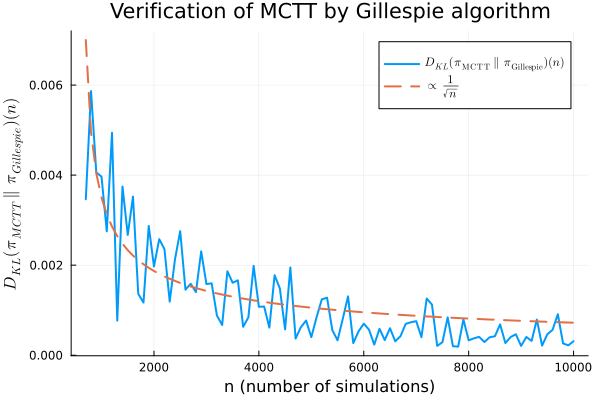

In [26]:
n_set = 1:length(n_values)
sqrt_curve = 0.007* 1 ./ sqrt.(n_set)
# Now plot the results
plot(n_values, divergences, 
     xlabel="n (number of simulations)", ylabel=L"D_{KL}(\pi_{MCTT} \parallel \pi_{Gillespie})(n)", 
     title="Verification of MCTT by Gillespie algorithm", 
     label=L"D_{KL}(\pi_{\mathrm{MCTT}} \parallel \pi_{\mathrm{Gillespie}})(n)", lw=2, legend=:topright)
plot!(n_values, sqrt_curve, label=L"\propto \frac{1}{\sqrt{n}}", lw=2, linestyle=:dash)

4.2.3 Example 2: Enzyme-Catalytic Reaction

Defining Enzyme-Catalytic Reaction

In [27]:
crn_ecr = @reaction_network begin
    k, E + S --> ES
    1.0, ES --> E + S
end

Model ##ReactionSystem#267
States (3):
  E(t)
  S(t)
  ES(t)
Parameters (1):
  k

Function to compute stationary distribution using MCTT

In [28]:
function mctt_for_crn_ecr(k::Float64, N::Int64, M::Int64)
    M=4
    Z=Int64((N-M)/2)
    # For demonstration, let's assume the model predicts a uniform distribution
    states = Z + 1
    P = Matrix{Float64}(undef, states, states)
    for i in 1:states, j in 1:states
        P[i, j] = 0.0
    end
    for i in 0:Z
        if i < Z
            P[i+1, i+2] = (Z-i)
        end
        if i > 0
            P[i+1, i] =  k*i*(i+M)# Pi,i-1
        end
        P[i+1, i+1] = -(1*(Z-i)+k*i*(i+M))
    end
    n=Z+1
    A= P
    z=Float64[]
    for i in 1:n
        minor = A[[1:i-1; i+1:n], [1:i-1; i+1:n]]
        pi = det(minor)
        push!(z,pi)
    end
    s = sum(z)
    values = [zi / s for zi in z]
    return values
end

mctt_for_crn_ecr (generic function with 1 method)

Taking true data as k=0.3, N=12 and M=4

In [29]:
true_data = mctt_for_crn_ecr(0.3,12,4)

5-element Vector{Float64}:
 0.14997354963851173
 0.39992946570269794
 0.33327455475224826
 0.10580144595309474
 0.011020983953447376

Function to compute stationary distribution using Gillespie algorithm for n number of simulations

In [30]:
function gillespie_for_crn_ecr(n::T,N::Int64,M::Int64) where T<:Real 
    CRN_ECR = 
    @reaction_network CRN_ECR begin
        0.3, E+S → ES  #as we took k=0.3 in true data
        1.0, ES → E+S
    end
    Z = Int64((N-M)/2)
    function get_state(u)
        E = Int(u[1])
        return E+1  
    end
    states = [(i, i+M, Z-i) for i in 0:Z]
    d=[]
    m=n
    for t in 1:m
        u0 = [2,6,2] #initializing molecular counts
        tspan = (Float64.(0.0), Float64.(100))  # Time from 0 to 100
        # Create a DiscreteProblem
        prob = DiscreteProblem(CRN_ECR, u0, tspan)
        jump_prob = JumpProblem(CRN_ECR, prob, Direct())
        sol = solve(jump_prob, SSAStepper())
        st = sol[end]
        push!(d,st)
    end
    states = [get_state(u) for u in d]
    digit_count = [count(x -> x == i, states) for i in 1:Z+1]
    total_counts = sum(digit_count)
    stationary_distribution = [digit_count[i] / total_counts for i in 1:Z+1]
    return stationary_distribution
end

gillespie_for_crn_ecr (generic function with 1 method)

Following the same approach here from 4.2.2

In [31]:
function verification_function_crn_ecr(n::T) where T<:Real
    model_data = gillespie_for_crn_ecr(n,12,4) #N=12
    return kl_divergence(true_data, model_data)
end
# Define the range of number of simulations
n_values = 700:100:10000  # Adjust the range and step as needed
# Store the KL divergence results
divergences = Float64[]  # Initialize an empty array to store results
# Loop over the number of simulations, calculating the KL divergence for each
for n in n_values
    divergence = verification_function_crn_ecr(n)
    push!(divergences, divergence)
end

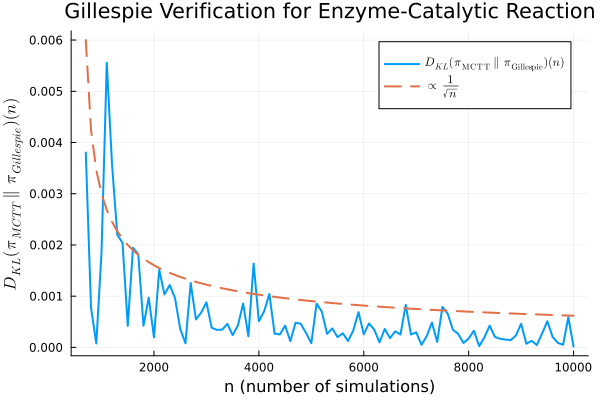

In [32]:
n_set = 1:length(n_values)
sqrt_curve = 0.006* 1 ./ sqrt.(n_set)
# Now plot the results
plot(n_values, divergences, 
     xlabel="n (number of simulations)", ylabel=L"D_{KL}(\pi_{MCTT} \parallel \pi_{Gillespie})(n)", 
     title="Gillespie Verification for Enzyme-Catalytic Reaction", 
     label=L"D_{KL}(\pi_{\mathrm{MCTT}} \parallel \pi_{\mathrm{Gillespie}})(n)", lw=2, legend=:topright)
plot!(n_values, sqrt_curve, label=L"\propto \frac{1}{\sqrt{n}}", lw=2, linestyle=:dash)